In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from chart_studio import plotly as py
import plotly.graph_objs as go
from plotly import tools
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
%matplotlib inline
import datetime, warnings, scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
warnings.filterwarnings("ignore")

In [2]:
airlines = pd.read_csv('data/airlines.csv')
airports= pd.read_csv('data/airports.csv')
flights = pd.read_csv('data/flights.csv', low_memory=False)
flights_2019 = pd.read_csv('data/flights_sample_3m_renamed.csv', low_memory=False)
print (airlines.shape)
print (airports.shape)
print (flights.shape)
print (flights_2019.shape)

(14, 2)
(322, 7)
(5819079, 31)
(3000000, 30)


Each entry of the flights.csv & flights_2019.csv files represents a flight with 5800000+ flights in 2015 and 3000000 in 2019. These
flights are described according to 31/30 (2019 doesn't contain the tail_number column) variables.
YEAR, MONTH, DAY, DAY_OF_WEEK: dates of the flight
* **AIRLINE**: identification number assigned by the US government to identify a unique airline
* **SCHEDULED_DEPARTURE** and **SCHEDULED_ARRIVAL** : scheduled/approximated times of taking off and landing
* **DEPARTURE_TIME** and **ARRIVAL_TIME**: real times at which the previously mentioned variables happened
* **DEPARTURE_DELAY** and **ARRIVAL_DELAY**: difference (in minutes) between planned and real times
* **DISTANCE**: distance (in miles)


# Exploring if cancelations reasons match up with cancelation numbers


In [3]:
print (flights.shape[0]*flights.CANCELLED.mean())
print (flights.shape[0] - flights.CANCELLATION_REASON.isnull().sum().sum())

89884.0
89884


In [4]:
print (flights_2019.shape[0]*flights_2019.CANCELLED.mean())
print (flights_2019.shape[0] - flights_2019.CANCELLATION_REASON.isnull().sum().sum())

79140.0
79140


# The numbers fit, so let's check if only the cancelled flights have a cancellation reason

In [5]:
print (flights['ARRIVAL_DELAY'][flights['ARRIVAL_DELAY'] >= 15].count())
print (flights.shape[0] - flights.AIR_SYSTEM_DELAY.isnull().sum().sum())

1063439
1063439


In [6]:
print (flights_2019['ARRIVAL_DELAY'][flights_2019['ARRIVAL_DELAY'] >= 15].count())
print (flights_2019.shape[0] - flights_2019.AIR_SYSTEM_DELAY.isnull().sum().sum())

533863
533863


We can now see that only real delays are in both of the data sets ( >=15 minute & with delay code )

In [7]:
def plot_airport_flights(airports, flights, year):
    count_flights = flights['ORIGIN_AIRPORT'].value_counts()
    colors = ['lightyellow', 'yellow', 'orange', 'orangered', 'red']
    size_limits = [1, 100, 1000, 10000, 100000, 1000000]
    labels = [f"{size_limits[i]} <.< {size_limits[i+1]}" for i in range(len(size_limits) - 1)]
    fig, ax = plt.subplots(figsize=(11, 11))
    # Create Basemap instance
    map = Basemap(resolution='i', llcrnrlon=-180, urcrnrlon=-50,
    llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0, ax=ax)
    map.shadedrelief()
    map.drawcoastlines()
    map.drawcountries(linewidth=3)
    map.drawstates(color='0.3')
    
    # Plot airports on the map
    for _, (code, lat, lon) in airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
        x, y = map(lon, lat)
        flight_count = count_flights.get(code, 0)
        isize = [i for i, val in enumerate(size_limits) if val < flight_count]
        ind = isize[-1] if isize else 0
        map.plot(x, y, 'o', markersize=ind + 5, markeredgewidth=1,
                 color=colors[ind], markeredgecolor='k', label=labels[ind])

    # Remove duplicate labels and set their order
    handles, labels = ax.get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    key_order = ('1 <.< 100', '100 <.< 1000', '1000 <.< 10000',
                 '10000 <.< 100000', '100000 <.< 1000000')
    new_label = OrderedDict((key, by_label[key]) for key in key_order if key in by_label)
    ax.legend(new_label.values(), new_label.keys(), loc='upper right', prop={'size': 11}, 
              title='Number of flights per year', frameon=True, framealpha=1)
    plt.show()

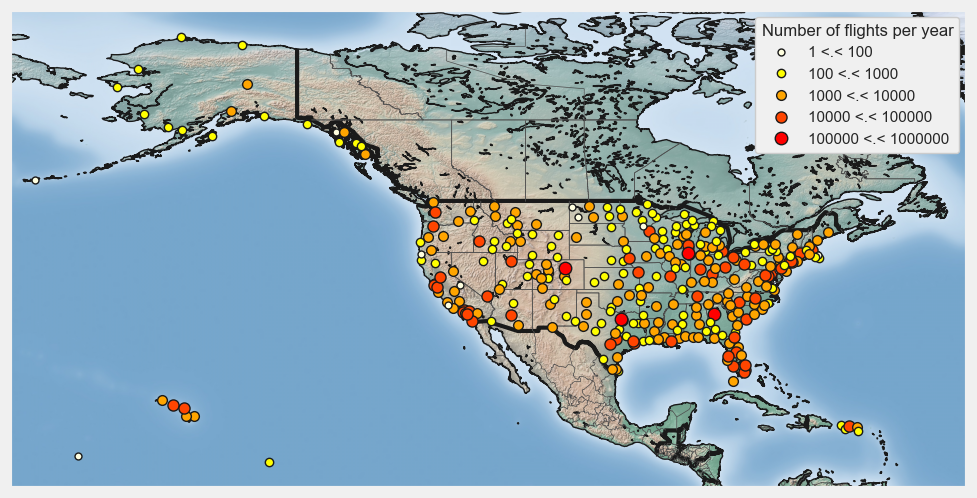

In [8]:
plot_airport_flights(airports, flights_2019, 2019)

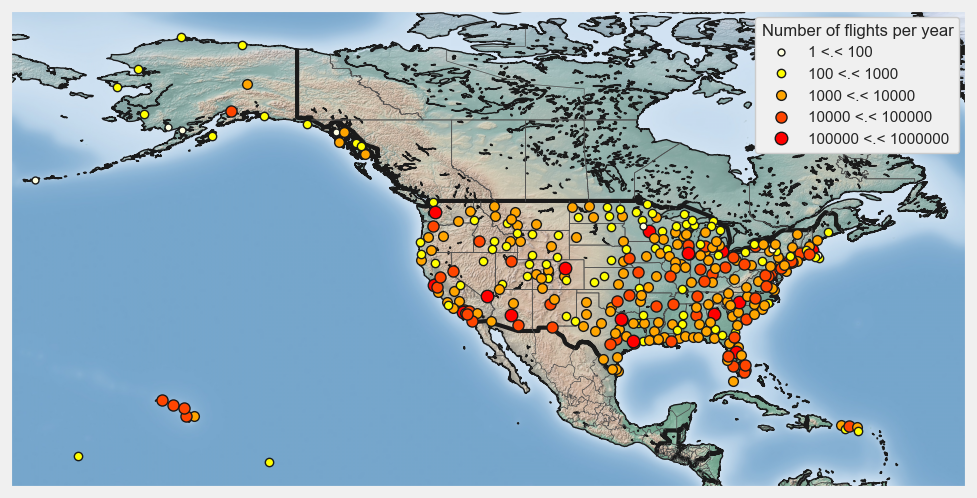

In [9]:
plot_airport_flights(airports, flights, 2015)

# Bringing DataFrames period to DATETIME format

In [10]:
flights['DATE'] = pd.to_datetime(flights[['YEAR','MONTH', 'DAY']])
flights_2019['DATE'] = pd.to_datetime(flights_2019[['YEAR','MONTH', 'DAY']])

The **SCHEDULED_DEPARTURE** column, is represented by 4 digit numbers, first two representing the hour and last two, the
minutes. This format is not convenient, thus we need to convert it, and merge it flight date.


In [11]:
def format_hour(chaine):
    if pd.isnull(chaine):
        return np.nan 
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        hour = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return hour

# Function that combines a date and time to produce a datetime.datetime
def combine_date_hour(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])

#_______________________________________________________________________________
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):
    list = []
    for index, cols in df[['DATE', col]].iterrows():
        if pd.isnull(cols[1]):
            list.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            list.append(combine_date_hour(cols))
        else:
            cols[1] = format_hour(cols[1])
            list.append(combine_date_hour(cols))
    return pd.Series(list)


In [12]:
# TAKES LONG TO RUN

flights['SCHEDULED_DEPARTURE'] = create_flight_time(flights, 'SCHEDULED_DEPARTURE')
flights['DEPARTURE_TIME'] = flights['DEPARTURE_TIME'].apply(format_hour)
flights['SCHEDULED_ARRIVAL'] = flights['SCHEDULED_ARRIVAL'].apply(format_hour)
flights['ARRIVAL_TIME'] = flights['ARRIVAL_TIME'].apply(format_hour)


In [13]:
# TAKES LONG TO RUN

flights_2019['SCHEDULED_DEPARTURE'] = create_flight_time(flights_2019, 'SCHEDULED_DEPARTURE')
flights_2019['DEPARTURE_TIME'] = flights_2019['DEPARTURE_TIME'].apply(format_hour)
flights_2019['SCHEDULED_ARRIVAL'] = flights_2019['SCHEDULED_ARRIVAL'].apply(format_hour)
flights_2019['ARRIVAL_TIME'] = flights_2019['ARRIVAL_TIME'].apply(format_hour)


In [14]:
# saving csv in case of something (creating these takes a lot of time)

flights.to_csv('flights', encoding='utf-8', index=False)
flights_2019.to_csv('flights_2019', encoding='utf-8', index=False)

In [15]:
flights = pd.read_csv('flights', low_memory=False)
flights_2019 = pd.read_csv('flights_2019', low_memory=False)

The **DEPARTURE_TIME** and **ARRIVAL_TIME** variables can be misleading because they don't include dates. For example, the first
entry in the dataframe shows a scheduled departure at **00:05** on **January 1st**. The **DEPARTURE_TIME** is listd as **23:54**, so it's
unclear if the flight left early or had a large delay. Therefore, the **DEPARTURE_DELAY** and **ARRIVAL_DELAY** variables are more
useful since they directly show the delays in minutes. Thus, we will not use the **DEPARTURE_TIME** and **ARRIVAL_TIME** variables in
the following analysis.


In [16]:
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR',
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']

flights.drop(variables_to_remove, axis = 1, inplace = True)
flights = flights[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
                   'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
                   'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
                   'SCHEDULED_TIME', 'ELAPSED_TIME']]
flights[:5]

AIRLINE ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  \
0      AS            ANC                 SEA  2015-01-01 00:05:00   
1      AA            LAX                 PBI  2015-01-01 00:10:00   
2      US            SFO                 CLT  2015-01-01 00:20:00   
3      AA            LAX                 MIA  2015-01-01 00:20:00   
4      AS            SEA                 ANC  2015-01-01 00:25:00   

  DEPARTURE_TIME  DEPARTURE_DELAY SCHEDULED_ARRIVAL ARRIVAL_TIME  \
0       23:54:00            -11.0          04:30:00     04:08:00   
1       00:02:00             -8.0          07:50:00     07:41:00   
2       00:18:00             -2.0          08:06:00     08:11:00   
3       00:15:00             -5.0          08:05:00     07:56:00   
4       00:24:00             -1.0          03:20:00     02:59:00   

   ARRIVAL_DELAY  SCHEDULED_TIME  ELAPSED_TIME  
0          -22.0           205.0         194.0  
1           -9.0           280.0         279.0  
2            5.0           286.0         293.0  
3           -9.0           285.0         281.0  
4          -21.0           235.0         215.0

In [17]:
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR',
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'AIR_TIME']

flights_2019.drop(variables_to_remove, axis = 1, inplace = True)
flights_2019 = flights_2019[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
                             'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
                             'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
                             'SCHEDULED_TIME', 'ELAPSED_TIME']]
flights_2019[:5]


AIRLINE ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  \
0      UA            FLL                 EWR  2019-01-09 11:55:00   
1      DL            MSP                 SEA  2022-11-19 21:20:00   
2      UA            DEN                 MSP  2022-07-22 09:54:00   
3      DL            MSP                 SFO  2023-03-06 16:09:00   
4      NK            MCO                 DFW  2020-02-23 18:40:00   

  DEPARTURE_TIME  DEPARTURE_DELAY SCHEDULED_ARRIVAL ARRIVAL_TIME  \
0       11:51:00             -4.0          15:01:00     14:47:00   
1       21:14:00             -6.0          23:15:00     23:10:00   
2       10:00:00              6.0          12:52:00     12:52:00   
3       16:08:00             -1.0          18:29:00     18:53:00   
4       18:38:00             -2.0          20:41:00     20:40:00   

   ARRIVAL_DELAY  SCHEDULED_TIME  ELAPSED_TIME  
0          -14.0           186.0         176.0  
1           -5.0           235.0         236.0  
2            0.0           118.0         112.0  
3           24.0           260.0         285.0  
4           -1.0           181.0         182.0

# Examining how complete the data is:

In [18]:
missing_flights = flights.isnull().sum(axis=0).reset_index()
missing_flights.columns = ['variable', 'missing values']
missing_flights['filling factor (%)']=(flights.shape[0]-missing_flights['missing values'])/flights.shape[0]*100
missing_flights.sort_values('filling factor (%)').reset_index(drop = True)

variable  missing values  filling factor (%)
0         ARRIVAL_DELAY          105071           98.194371
1          ELAPSED_TIME          105071           98.194371
2          ARRIVAL_TIME           92513           98.410178
3        DEPARTURE_TIME           86153           98.519474
4       DEPARTURE_DELAY           86153           98.519474
5        SCHEDULED_TIME               6           99.999897
6               AIRLINE               0          100.000000
7        ORIGIN_AIRPORT               0          100.000000
8   DESTINATION_AIRPORT               0          100.000000
9   SCHEDULED_DEPARTURE               0          100.000000
10    SCHEDULED_ARRIVAL               0          100.000000

In [19]:
missing_flights_2019 = flights_2019.isnull().sum(axis=0).reset_index()
missing_flights_2019.columns = ['variable', 'missing values']
missing_flights_2019['filling factor (%)']=(flights_2019.shape[0]-missing_flights_2019['missing values'])/flights_2019.shape[0]*100
missing_flights_2019.sort_values('filling factor (%)').reset_index(drop = True)

variable  missing values  filling factor (%)
0         ARRIVAL_DELAY           86198           97.126733
1          ELAPSED_TIME           86198           97.126733
2          ARRIVAL_TIME           79942           97.335267
3       DEPARTURE_DELAY           77644           97.411867
4        DEPARTURE_TIME           77615           97.412833
5        SCHEDULED_TIME              14           99.999533
6               AIRLINE               0          100.000000
7        ORIGIN_AIRPORT               0          100.000000
8   DESTINATION_AIRPORT               0          100.000000
9   SCHEDULED_DEPARTURE               0          100.000000
10    SCHEDULED_ARRIVAL               0          100.000000

In [20]:
abbr_companies = airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()
airlines

IATA_CODE                       AIRLINE
0         UA         United Air Lines Inc.
1         AA        American Airlines Inc.
2         US               US Airways Inc.
3         F9        Frontier Airlines Inc.
4         B6               JetBlue Airways
5         OO         Skywest Airlines Inc.
6         AS          Alaska Airlines Inc.
7         NK              Spirit Air Lines
8         WN        Southwest Airlines Co.
9         DL          Delta Air Lines Inc.
10        EV   Atlantic Southeast Airlines
11        HA        Hawaiian Airlines Inc.
12        MQ  American Eagle Airlines Inc.
13        VX                Virgin America

In [21]:
def get_stats(group):
 return {'min': group.min(), 'max': group.max(),
 'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats_2015 = flights['DEPARTURE_DELAY'].groupby(flights['AIRLINE']).apply(get_stats).unstack()
global_stats_2015 = global_stats_2015.sort_values('count')
global_stats_2015

min     max      count       mean
AIRLINE                                    
VX      -24.0   644.0    61385.0   9.022595
HA      -27.0  1433.0    76119.0   0.485713
F9      -46.0  1112.0    90290.0  13.350858
NK      -37.0   836.0   115454.0  15.944766
AS      -82.0   963.0   171910.0   1.785801
US      -35.0   759.0   194825.0   6.141137
B6      -31.0  1006.0   262843.0  11.514353
MQ      -36.0  1544.0   280282.0  10.125188
UA      -40.0  1314.0   509534.0  14.435441
EV      -55.0  1274.0   557294.0   8.715934
OO      -56.0  1378.0   579086.0   7.801104
AA      -68.0  1988.0   715598.0   8.900856
DL      -61.0  1289.0   872177.0   7.369254
WN      -28.0   665.0  1246129.0  10.581986

In [22]:
global_stats_2019 = flights_2019['DEPARTURE_DELAY'].groupby(flights_2019['AIRLINE']).apply(get_stats).unstack()
global_stats_2019 = global_stats_2019.sort_values('count')
global_stats_2019

min     max     count       mean
AIRLINE                                   
EV      -54.0  1839.0   18028.0  12.774462
QX      -38.0   754.0   20284.0   4.832775
HA      -31.0  1615.0   31730.0   5.089537
G4      -51.0  1778.0   50367.0  13.907797
YV      -56.0  2036.0   62686.0  12.277383
F9      -46.0  1375.0   62846.0  16.033574
NK      -47.0  1302.0   93433.0  12.981880
AS      -73.0   771.0   98616.0   4.640018
OH      -43.0  1919.0  103854.0   7.972124
B6      -62.0  1834.0  109882.0  18.322555
9E      -90.0  2579.0  110140.0   5.951135
MQ      -33.0  1543.0  117758.0   6.728256
YX      -66.0  1352.0  138611.0   5.804359
UA      -82.0  1451.0  249083.0  11.217032
OO      -68.0  2327.0  336153.0   9.458294
AA      -89.0  2966.0  372441.0  12.609895
DL      -49.0  1244.0  389339.0   8.106748
WN      -52.0   648.0  557105.0  10.816957

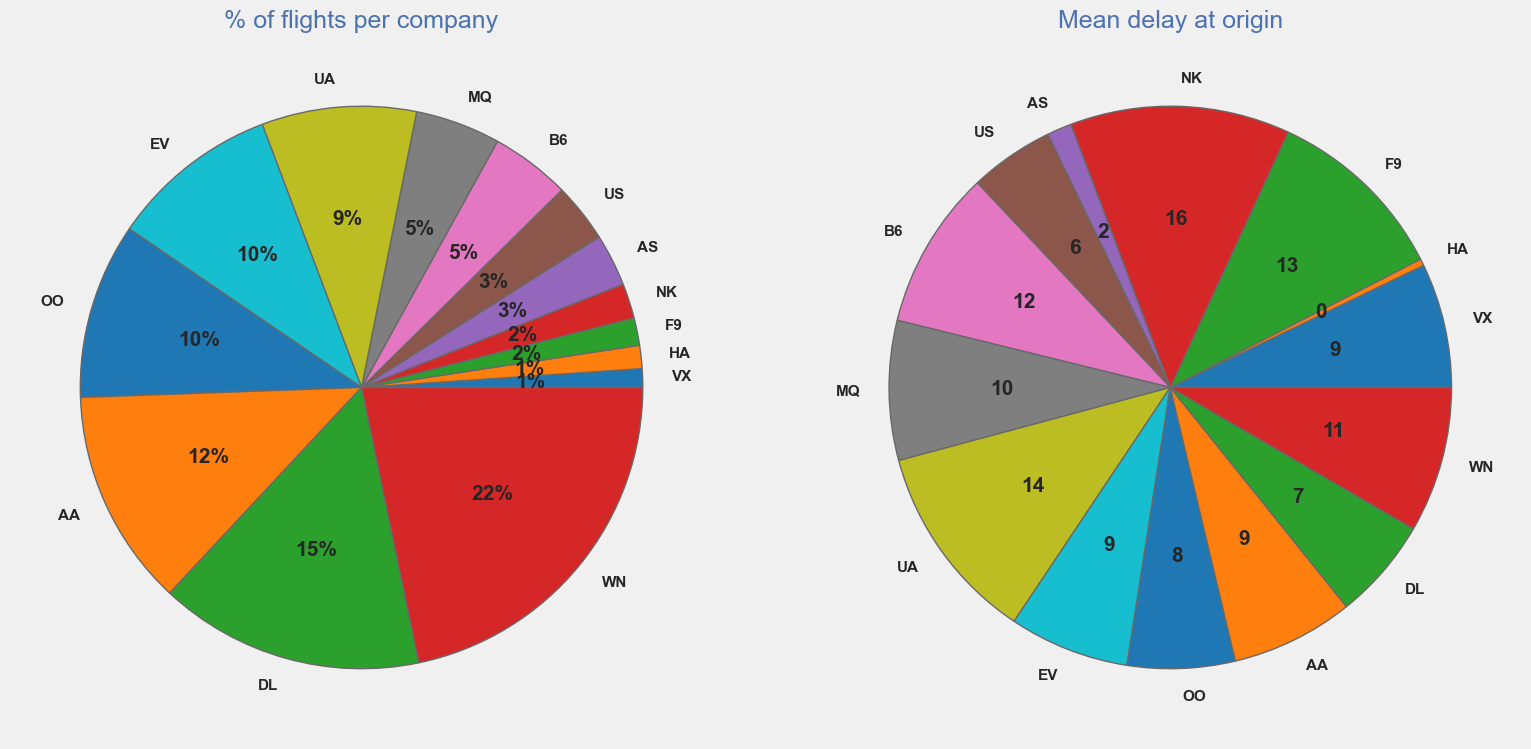

In [23]:
# Set font properties
mpl.rc('font', family='Arial', weight='bold', size=15)

# Define colors
base_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Extend or repeat colors to match the number of airlines
colors_pie = (base_colors * ((len(global_stats_2015) // len(base_colors)) + 1))[:len(global_stats_2015)]

# Create figure and subplots for pie charts
fig = plt.figure(figsize=(16, 15))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Pie chart 1: Number of flights
ax1.pie(global_stats_2015['count'], labels=global_stats_2015.index, colors=colors_pie,
        autopct='%1.0f%%', startangle=0)
ax1.set_title('% of flights per company', color='b', fontsize=18)

# Pie chart 2: Mean delay at departure
ax2.pie([max(s, 0) for s in global_stats_2015['mean']], labels=global_stats_2015.index, colors=colors_pie,
        autopct=lambda p: '{:.0f}'.format(p * sum(global_stats_2015['mean']) / 100), startangle=0)
ax2.set_title('Mean delay at origin', color='b', fontsize=18)

# Adjust layout for pie charts
plt.tight_layout(w_pad=3)
plt.show()

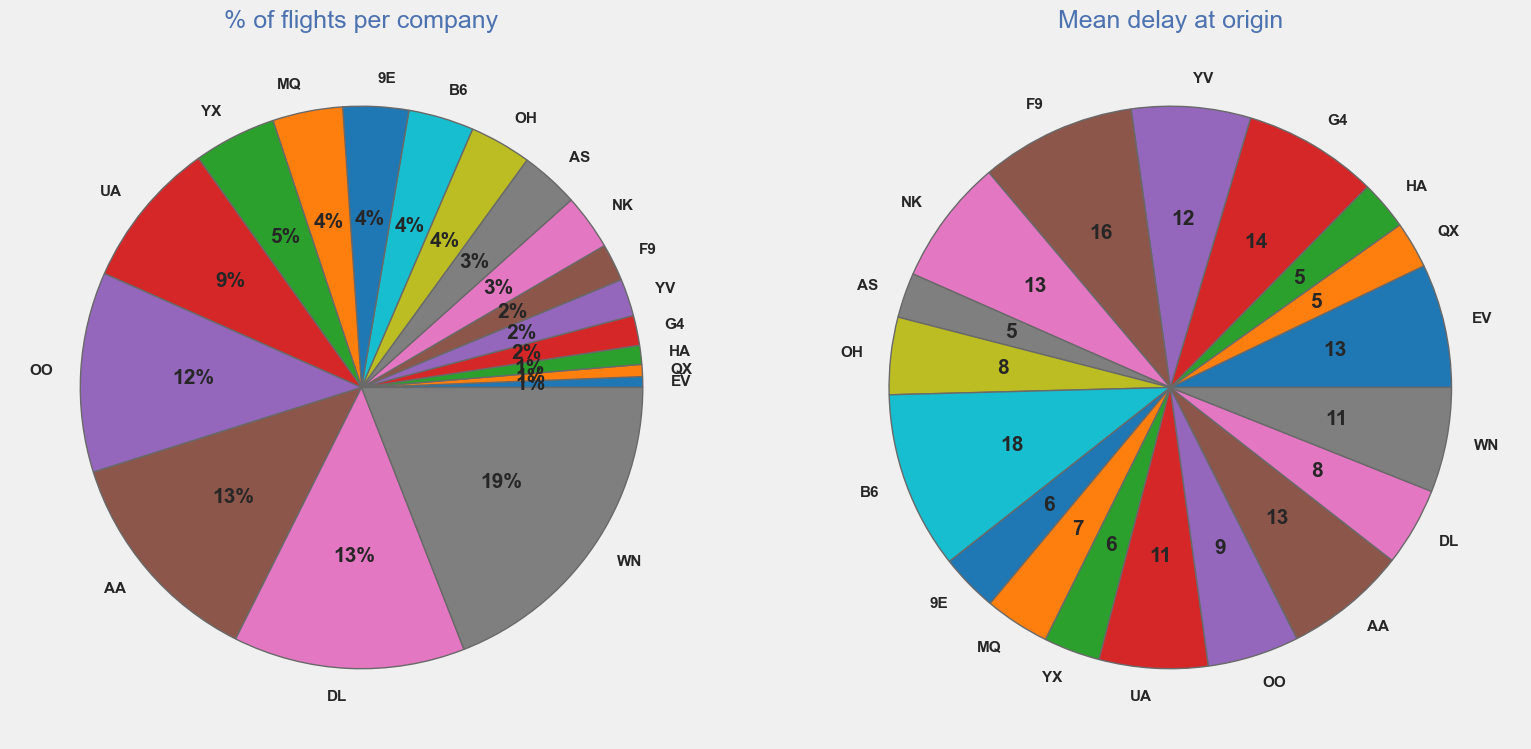

In [24]:
# Set font properties
mpl.rc('font', family='Arial', weight='bold', size=15)

# Define colors
base_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Extend or repeat colors to match the number of airlines
colors_pie = (base_colors * ((len(global_stats_2019) // len(base_colors)) + 1))[:len(global_stats_2019)]

# Create figure and subplots for pie charts
fig = plt.figure(figsize=(16, 15))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1]) 

# Pie chart 1: Number of flights
ax1.pie(global_stats_2019['count'], labels=global_stats_2019.index, colors=colors_pie,
        autopct='%1.0f%%', startangle=0)
ax1.set_title('% of flights per company', color='b', fontsize=18)

# Pie chart 2: Mean delay at departure
ax2.pie([max(s, 0) for s in global_stats_2019['mean']], labels=global_stats_2019.index, colors=colors_pie,
        autopct=lambda p: '{:.0f}'.format(p * sum(global_stats_2019['mean']) / 100), startangle=0)
ax2.set_title('Mean delay at origin', color='b', fontsize=18)

# Adjust layout for pie charts
plt.tight_layout(w_pad=3)
plt.show()

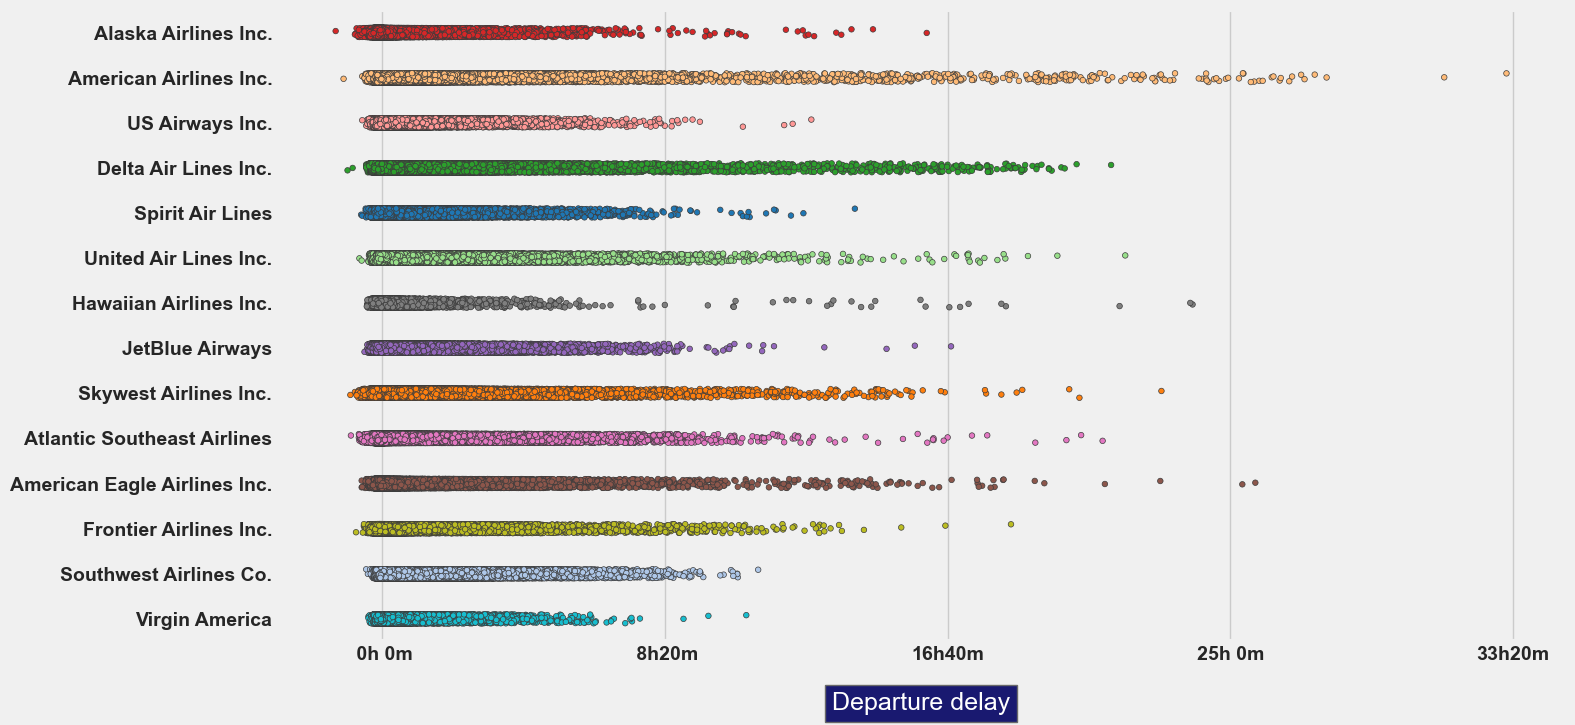

In [25]:
df2 = flights.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)

# Define colors for strip plot
base_colors_strip = ['#d62728', '#ffbb78', '#ff9896', '#2ca02c', '#1f77b4',
                     '#98df8a', '#7f7f7f', '#9467bd', '#ff7f0e', '#e377c2',
                     '#8c564b', '#bcbd22', '#aec7e8', '#17becf']

# Extend or repeat colors to match the number of airlines
colors_strip = (base_colors_strip * ((len(global_stats_2015) // len(base_colors_strip)) + 1))[:len(global_stats_2015)]


# Strip plot: Departure delays
fig, ax3 = plt.subplots(figsize=(16, 7.5))
sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", data=df2, size=4, palette=colors_strip,
              ax=ax3, jitter=True, linewidth=0.5)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*divmod(x, 60)) for x in ax3.get_xticks()], fontsize=14)
ax3.set_yticklabels(ax3.get_yticklabels(), fontsize=14)
ax3.set_xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5}, color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)

# Adjust layout for strip plot
plt.tight_layout()
plt.show()

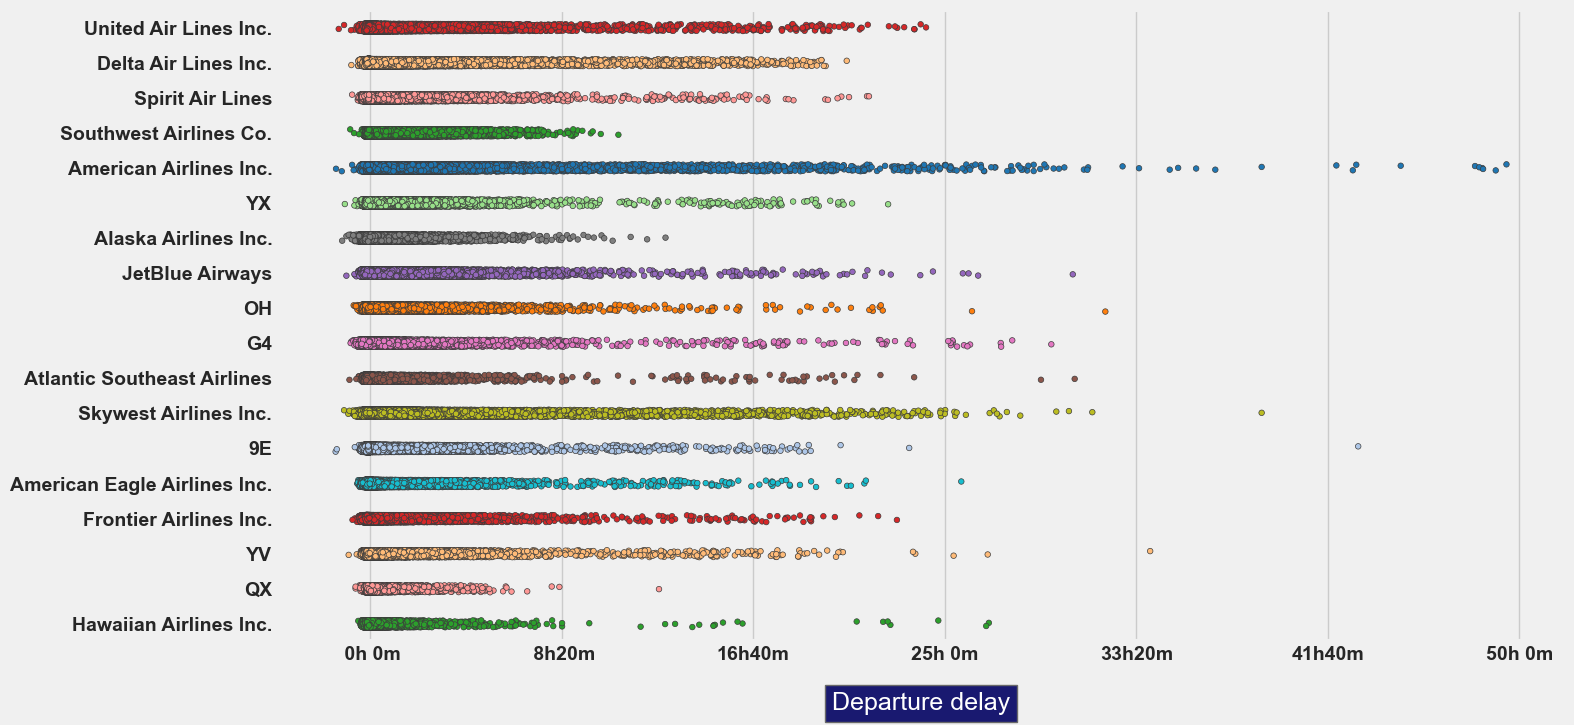

In [26]:
df2 = flights_2019.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)

# Define colors for strip plot
base_colors_strip = ['#d62728', '#ffbb78', '#ff9896', '#2ca02c', '#1f77b4',
                     '#98df8a', '#7f7f7f', '#9467bd', '#ff7f0e', '#e377c2',
                     '#8c564b', '#bcbd22', '#aec7e8', '#17becf']

# Extend or repeat colors to match the number of airlines
colors_strip = (base_colors_strip * ((len(global_stats_2019) // len(base_colors_strip)) + 1))[:len(global_stats_2019)]

# Strip plot: Departure delays
fig, ax3 = plt.subplots(figsize=(16, 7.5))
sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", data=df2, size=4, palette=colors_strip,
              ax=ax3, jitter=True, linewidth=0.5)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*divmod(x, 60)) for x in ax3.get_xticks()], fontsize=14)
ax3.set_yticklabels(ax3.get_yticklabels(), fontsize=14)
ax3.set_xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5}, color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)

# Adjust layout for strip plot
plt.tight_layout()
plt.show()

**Considering the first pie chart** showing the percentage of flights per airline, we observe some disparity among carriers. For
example, **Southwest Airlines (WN)** makes up about **20% of the flights**, which is comparable to the combined total of the **eight
smallest airlines**.

In contrast, the second pie chart shows less variation among airlines. Excluding some outliers, such as **Hawaiian Airlines** and
**Alaska Airlines** which have very low mean delays, a delay of about **11 ± 7 minutes** represents the average delays accurately. This
low average suggests that most airlines generally adhere to their schedules.

The final figures provides an overview of all delays recorded. It highlights the dispersion of data and contrasts the relative
uniformity seen in the second pie chart. While the average delays hover around **10 minutes**, showing that most flights depart on
time, there are occasional significant delays that can last several hours.


In [27]:
def plot_delay_distribution(df, delay_column, airline_column, abbr_companies):
 # Function to define how delays are grouped
 
    def delay_type(x):
        if x > 45:
            return 2
        elif x > 5:
            return 1
        else:
            return 0
            
    # Apply delay grouping
    df['DELAY_LEVEL'] = df[delay_column].apply(delay_type)

    # Define plot colors
    delay_colors = ['#2ca02c', '#ff7f0e', '#d62728']
 
    # Create figure and axis for bar plot
    fig, ax = plt.subplots(figsize=(14, 10))
 
    # Create bar plot with vertical orientation
    sns.barplot(
                x=airline_column, y=delay_column, hue='DELAY_LEVEL',
                data=df, ax=ax, palette=delay_colors, ci=None,
                estimator=lambda x: len(x) / len(df) * 100 # Plot percentage of flights
                )
    
    # Replace abbreviations with full names
    labels = [abbr_companies.get(item.get_text(), item.get_text()) for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels, rotation=90)
    
    # Customize plot appearance
    plt.setp(ax.get_xticklabels(), fontsize=12, weight='bold')
    plt.setp(ax.get_yticklabels(), fontsize=12, weight='normal')
    ax.xaxis.label.set_visible(False)
    ax.set_ylabel('Percentage of Flights (%)', fontsize=16, weight='bold', labelpad=10)
 
    # Customize legend
    legend_labels = ['On time (t ≤ 5 min)', 'Small delay (5 < t ≤ 45 min)', 'Large delay (t > 45 min)']
    L = ax.legend(title='Delay Level')
    for i, text in enumerate(L.get_texts()):
        text.set_text(legend_labels[i])
 
    # Adjust layout to prevent clipping
    plt.tight_layout()
    plt.show()


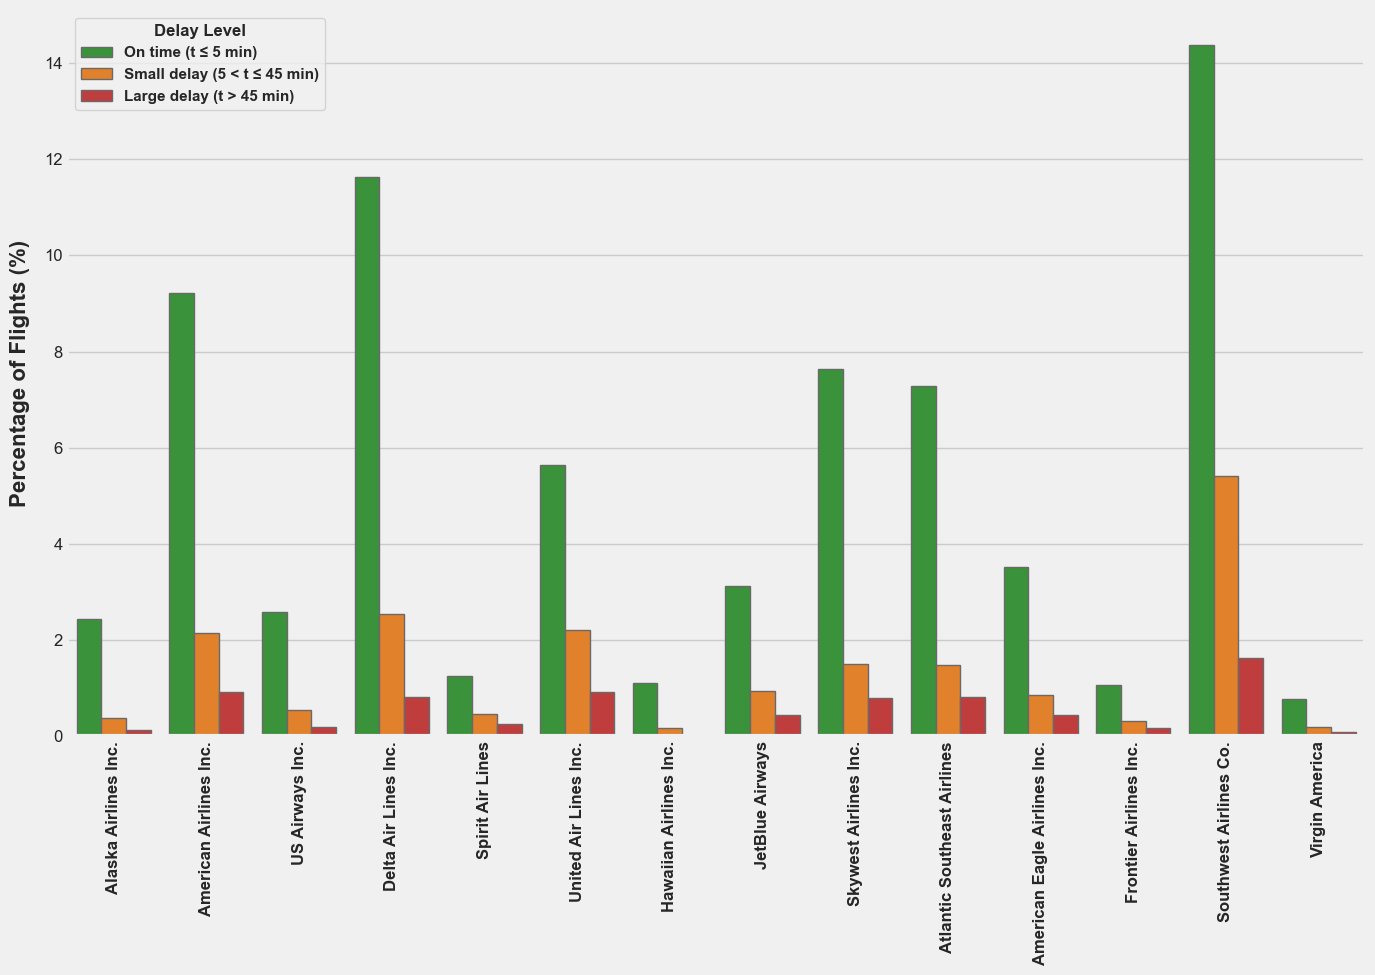

In [28]:
plot_delay_distribution(
    df=flights,
    delay_column='DEPARTURE_DELAY',
    airline_column='AIRLINE',
    abbr_companies=abbr_companies
)


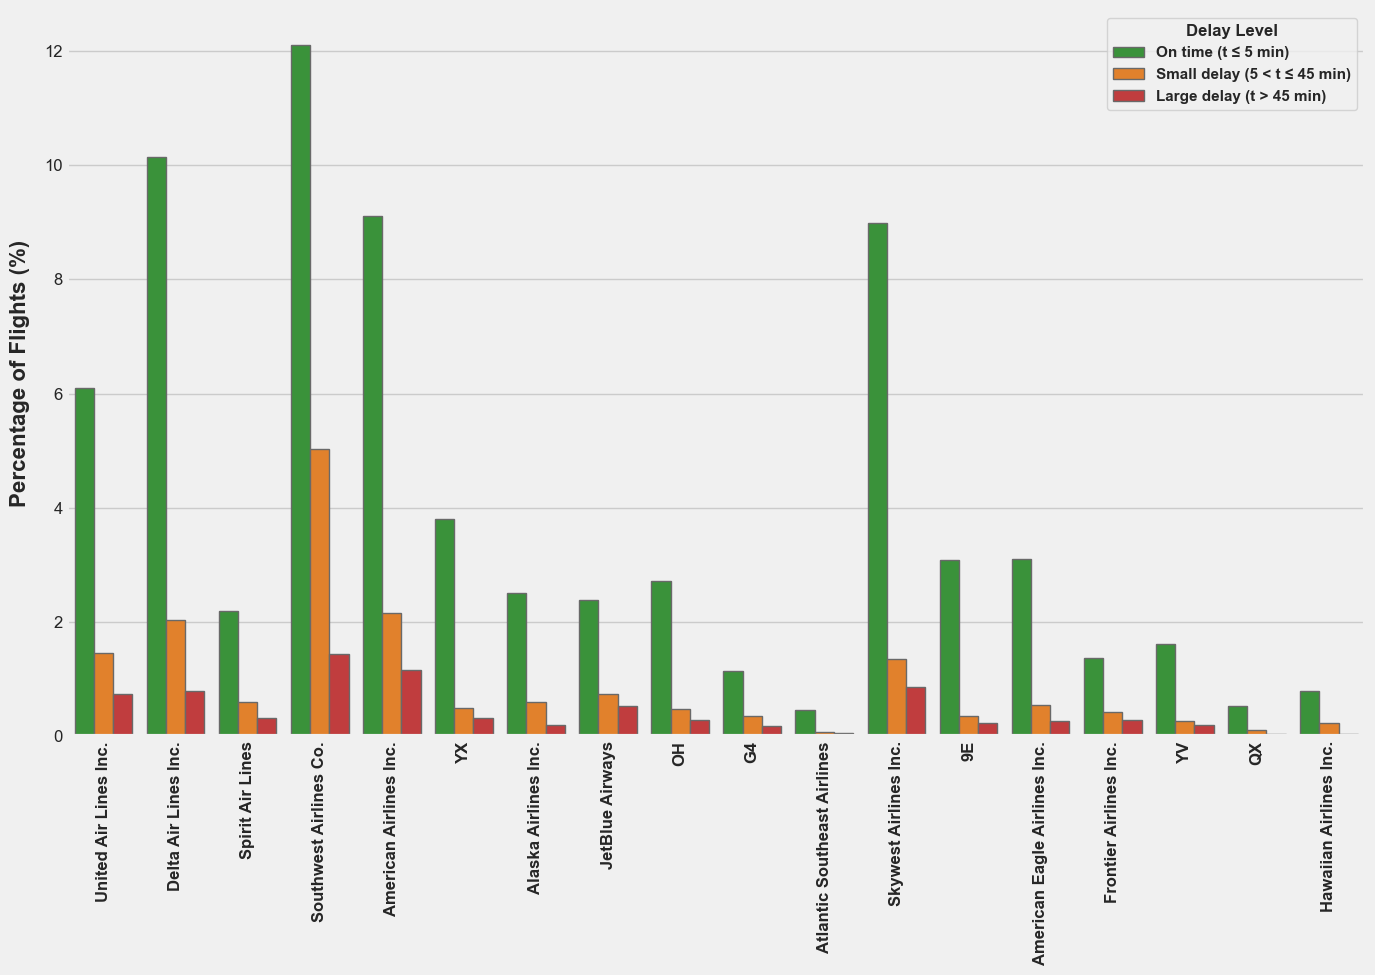

In [29]:
plot_delay_distribution(
    df=flights_2019,
    delay_column='DEPARTURE_DELAY',
    airline_column='AIRLINE',
    abbr_companies=abbr_companies
)

In [30]:
def plot_delay_histograms(dataframe, statistics, abbr_companies):
    # Model function used to fit the histograms 
    def func(x, a, b):
        return a * np.exp(-x / b)

    # Prepare data
    df2 = dataframe[['AIRLINE', 'DEPARTURE_DELAY']].replace({'AIRLINE': abbr_companies})
     
    # Initialize figure
    fig, axes = plt.subplots(5, 3, figsize=(11, 11), constrained_layout=True)
 
    # Flatten axes for easy iteration
    axes = axes.flatten()
 
    # Iterate over each airline and corresponding axis
    for i, (ax, carrier_code) in enumerate(zip(axes, statistics.index)):
        carrier_name = abbr_companies.get(carrier_code, carrier_code)
        delays = df2[df2['AIRLINE'] == carrier_name]['DEPARTURE_DELAY']

 
        # Fit the distribution
        n, bins, _ = ax.hist(delays, range=(15, 180), density=True, bins=60, alpha=0.75, color='blue')
        bin_centers = (bins[:-1] + bins[1:]) / 2
        popt, _ = curve_fit(func, bin_centers, n, p0=[1, 2])

        # Plot the fit curve
        ax.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=2)

        # Set title and tick labels
        ax.set_title(carrier_name, fontsize=14, fontweight='bold', color='darkblue')

        # Set tick labels
        if i >= len(axes) - 3: # Last row
            ax.set_xticklabels([f'{int(x // 60)}h{int(x % 60)}m' for x in ax.get_xticks()], rotation=45)
        else:
            ax.set_xticklabels([])

        # Axis labels
        if i % 3 == 0: # First column
            ax.set_ylabel('Normalized count of flights', fontsize=12, rotation=90)
        if i >= len(axes) - 3: # Last row
            ax.set_xlabel('Delay at origin', fontsize=12)

        # Display fit parameters
        ax.text(0.68, 0.7, f'a = {popt[0]:.2f}\nb = {popt[1]:.1f}',
                transform=ax.transAxes, fontsize=12, bbox={'facecolor': 'tomato', 'alpha': 0.8, 'pad': 5})

    # Adjust layout
    plt.show()

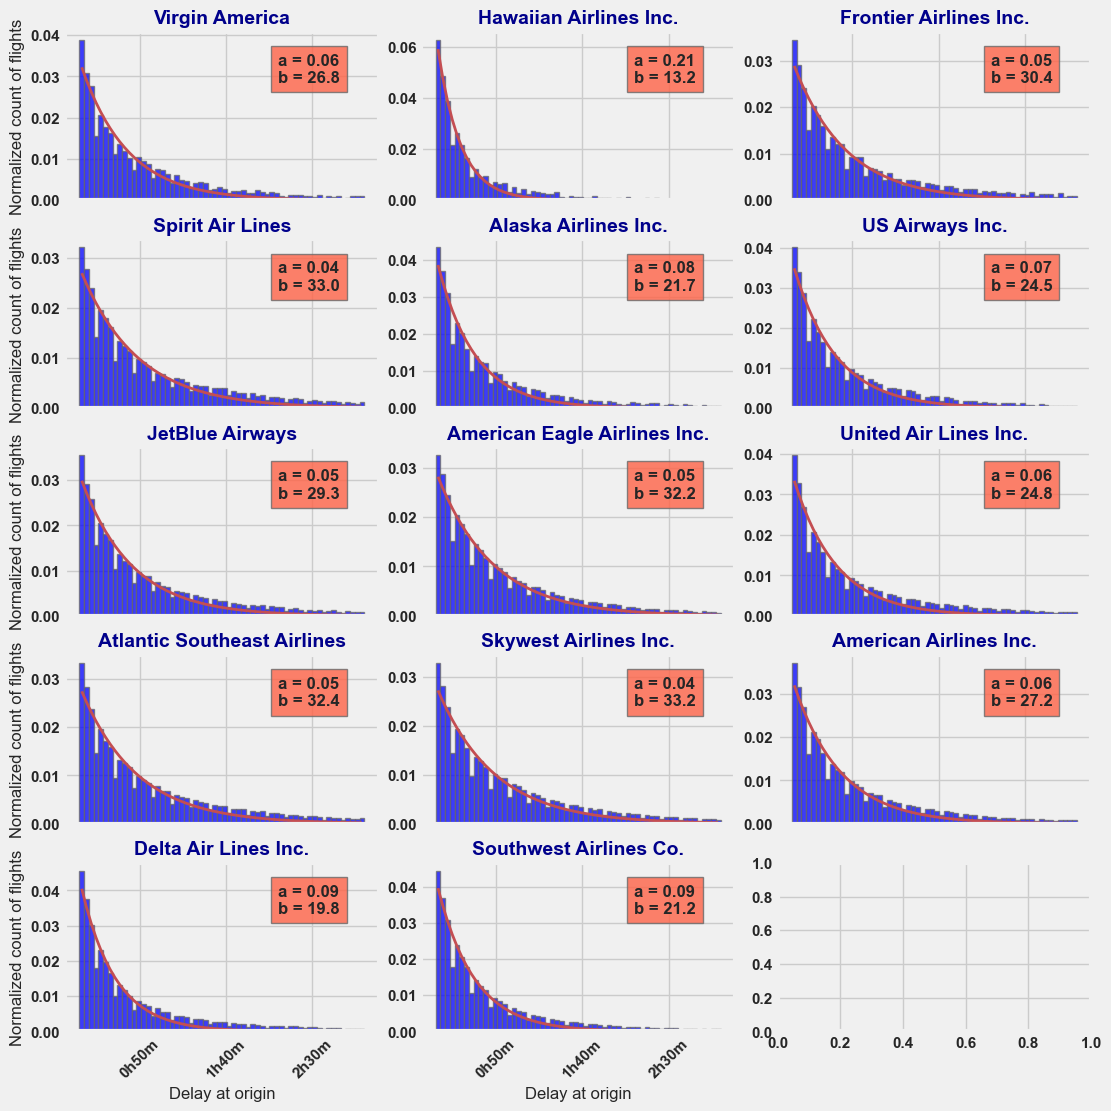

In [31]:
plot_delay_histograms(flights, global_stats_2015, abbr_companies)

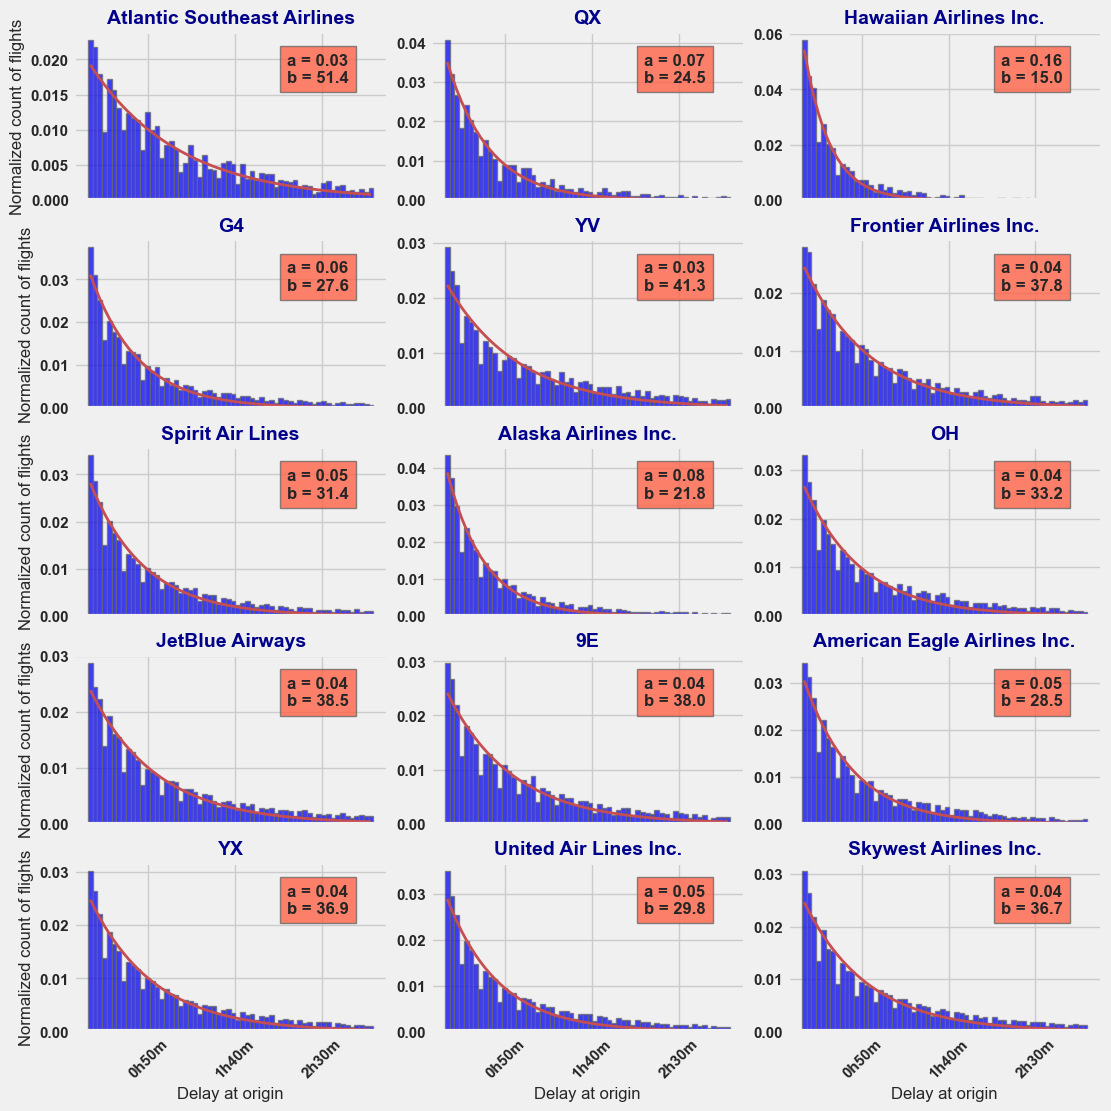

In [32]:
plot_delay_histograms(flights_2019, global_stats_2019, abbr_companies)

Occasionally, large delays can be registered. In this section, we examine in more detail the distribution of delays for every airline:

This figure illustrates the normalized distribution of delays that we have modeled with an exponential distribution $f(x) = a \cdot e^{-\frac{x}{b}}$. The parameters **'a'** and **'b'** obtained to describe each airline are given in the upper right corner of each panel. Note that the normalization of the distribution implies that $\int f(x) \, dx \approx 1$. Here, we do not have a strict equality since the normalization applies to the histograms but not to the model function. However, this relation entails that the **'a'** and **'b'** coefficients will be correlated with $a \propto \frac{1}{b}$, and hence, only one of these two values is necessary to describe the distributions. Finally, according to the value of either **'a'** or **'b'**, it is possible to establish a ranking of the companies: low values of **'a'** correspond to airlines with a large proportion of significant delays, and conversely, airlines that excel in punctuality will have high **'a'** values.


# Delays: take-off or landing?
These figures shows that arrival delays are usually shorter than departure delays, suggesting airlines speed up to minimize arrival
delays.


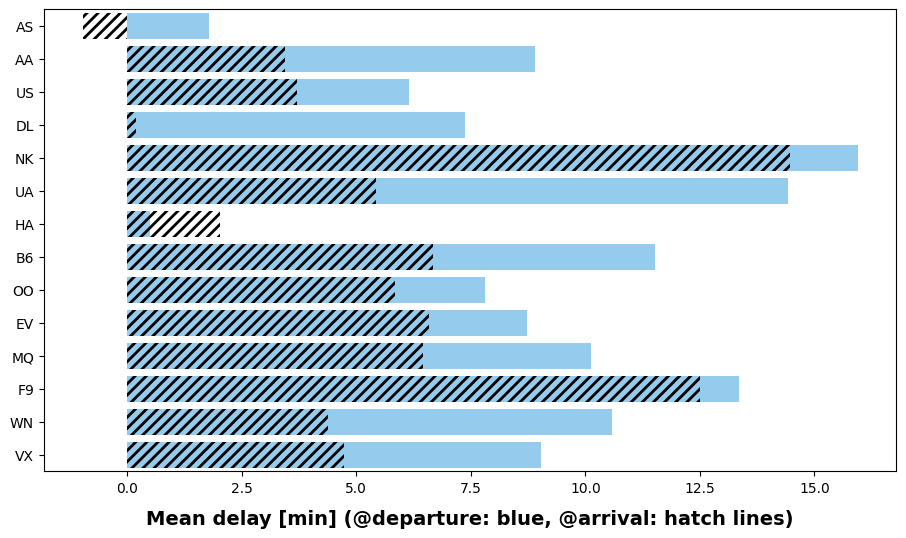

In [33]:
# Reverse mapping of abbr_companies
full_to_abbr = {v: k for k, v in abbr_companies.items()}

# Update matplotlib parameters
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0

# Create figure
fig = plt.figure(1, figsize=(11, 6))

# Plot bar charts
ax = sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=flights, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=flights, color="r", hatch='///',
                 alpha=0.0, ci=None)

# Update y-tick labels with abbreviations
labels = [full_to_abbr.get(item.get_text(), item.get_text()) for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)

# Customize plot
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight='bold', labelpad=10)

# Show plot
plt.show()

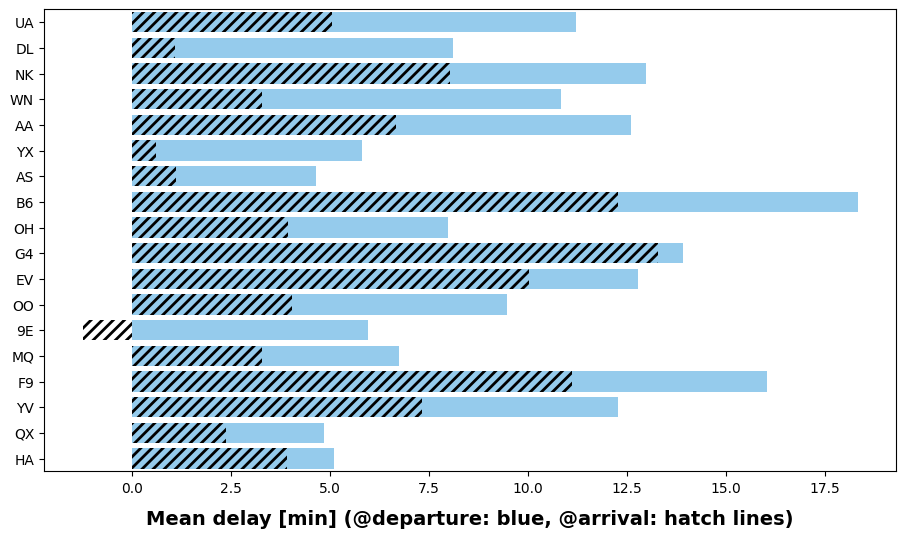

In [34]:
# Reverse mapping of abbr_companies
full_to_abbr = {v: k for k, v in abbr_companies.items()}

# Update matplotlib parameters
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0

# Create figure 
fig = plt.figure(1, figsize=(11, 6))

# Plot bar charts
ax = sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=flights_2019, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=flights_2019, color="r", hatch='///',
                 alpha=0.0, ci=None)

# Update y-tick labels with abbreviations
labels = [full_to_abbr.get(item.get_text(), item.get_text()) for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)

# Customize plot
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight='bold', labelpad=10)

# Show plot
plt.show()

In this figure, it is evident that arrival delays are typically less severe than departure delays. This suggests that airlines often adjust their flight speeds to make up time and decrease the delays by the time they arrive at their destination.

# Relation between the origin airport and delays

Starting by having a look at the number of destination airports for each airline:

In [35]:
print("Nb of airports: {}".format(len(flights['ORIGIN_AIRPORT'].unique())))


Nb of airports: 628


In [36]:
print("Nb of airports: {}".format(len(flights_2019['ORIGIN_AIRPORT'].unique())))

Nb of airports: 380


In [37]:
origin_nb = dict()
for carrier in abbr_companies.keys():
    list_origin_airport = flights[flights['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    origin_nb[carrier] = len(list_origin_airport)

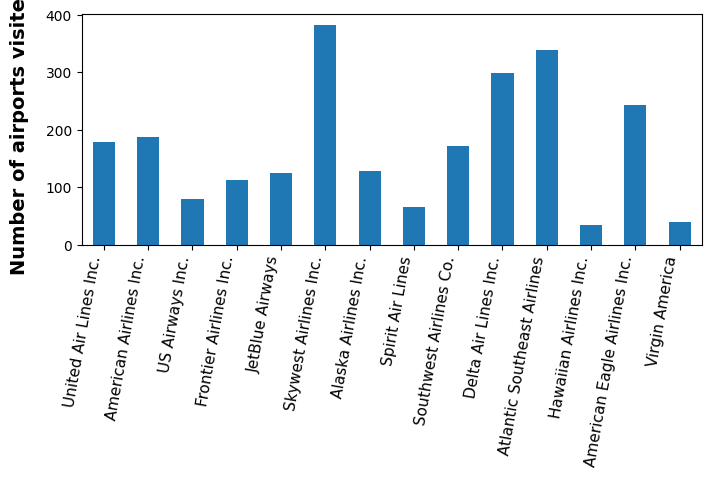

In [38]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

In [39]:
origin_nb = dict()
for carrier in abbr_companies.keys():
    list_origin_airport = flights_2019[flights_2019['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    origin_nb[carrier] = len(list_origin_airport)

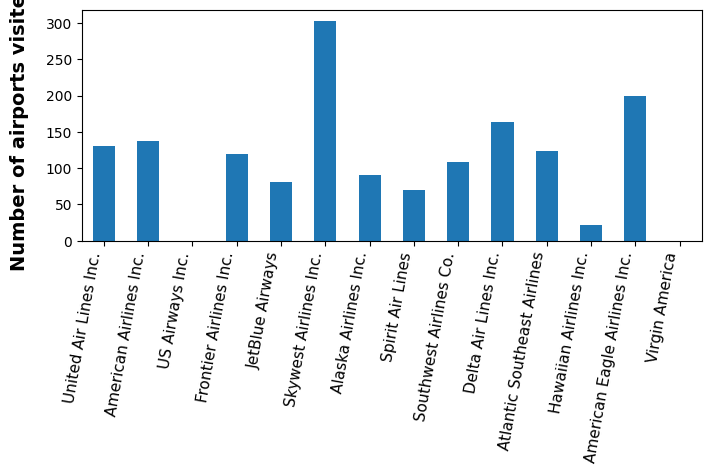

In [40]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

In this section, we will explore how delays vary depending on the origin airport and across different airlines. The initial step involves calculating the average delays for each airport:

Given the substantial number of airports involved, presenting all the data simultaneously would result in a cluttered graph, as it would encompass approximately 4400 values (i.e., 312 airports multiplied by 14 airlines). Therefore, we will only display a subset of the data:

In [41]:
temp = pd.read_csv('data/airports.csv')
identify_airport = temp.set_index('IATA_CODE')['CITY'].to_dict()
latitude_airport = temp.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = temp.set_index('IATA_CODE')['LONGITUDE'].to_dict()

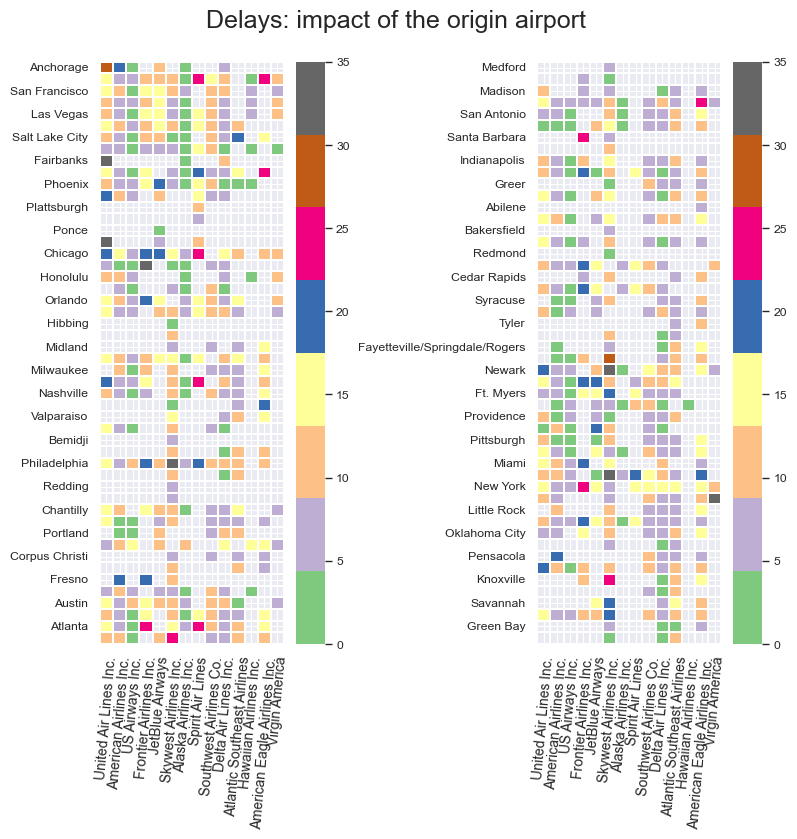

In [42]:
airport_mean_delays = pd.DataFrame(pd.Series(flights['ORIGIN_AIRPORT'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)
for carrier in abbr_companies.keys():
    df1 = flights[flights['AIRLINE'] == carrier]
    test = df1['DEPARTURE_DELAY'].groupby(flights['ORIGIN_AIRPORT']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean']

sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()
plt.plot()
plt.show()

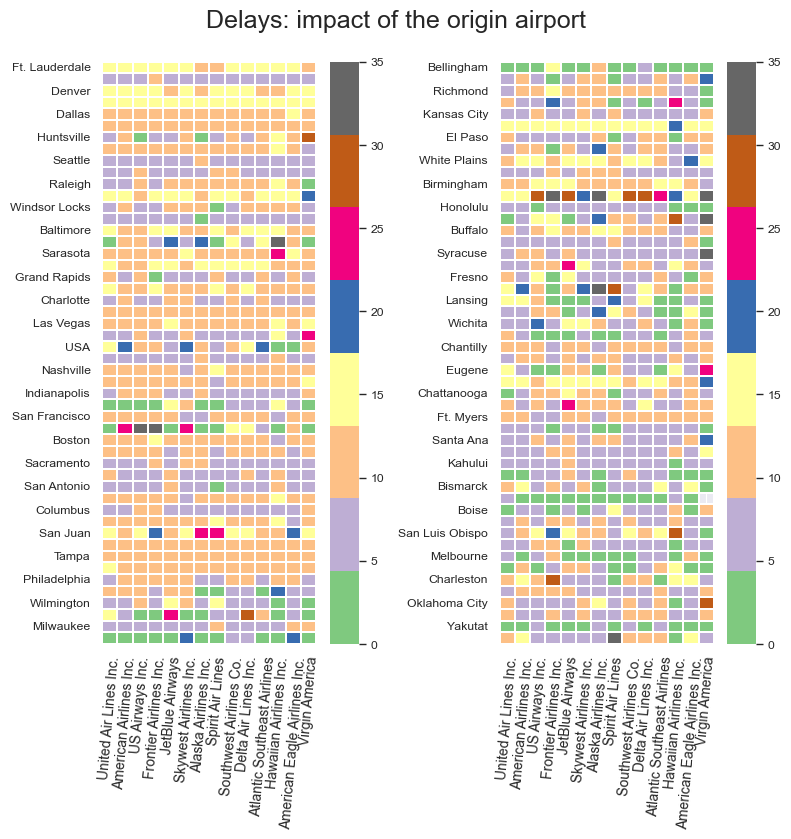

In [43]:
airport_mean_delays = pd.DataFrame(pd.Series(flights_2019['ORIGIN_AIRPORT'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)
for carrier in abbr_companies.keys():
    df1 = flights_2019[flights['AIRLINE'] == carrier]
    test = df1['DEPARTURE_DELAY'].groupby(flights_2019['ORIGIN_AIRPORT']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean']

sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()
plt.plot()
plt.show()